In [1]:
from import_library import *

In [28]:
def Colab(mainFile):
    from google.colab import drive
    drive.mount('/content/drive')
    dir = '/content/drive/MyDrive/Example/Stock/'
    df = pd.read_csv(dir+mainFile, sep=',',header = 0)
    return df 

# Configuration

In [3]:
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_WORKERS = 4
BATCH_SIZE = 8 # 64
PIN_MEMORY = True
LOAD_MODEL = False
LEARNING_RATE = 1e-4
NUM_EPOCHS = 100

In [5]:
mainFile = 'OCB Historical Data.csv'
# Colab
# df_raw = Colab(mainFile)
# Local
df_raw = pd.read_csv(mainFile, sep=',',header = 0)
df_raw.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,08/18/2023,"18,200.00","19,300.00","19,300.00","18,100.00",3.63M,-6.19%
1,08/17/2023,"19,400.00","19,500.00","19,650.00","19,400.00",1.48M,-1.02%
2,08/16/2023,"19,600.00","19,500.00","19,750.00","19,400.00",2.11M,0.26%
3,08/15/2023,"19,550.00","20,100.00","20,150.00","19,450.00",2.19M,-2.01%
4,08/14/2023,"19,950.00","19,800.00","20,150.00","19,800.00",2.01M,0.76%


# Data Wrangling

## Function

In [6]:
### Data_Wrangling.py
def DropNanValue(df,features):
  '''
  Drop nan Value
  ----------
  Attributes:
  df : pd.DataFrame
  features: list
      List of features
  ----------
  Returns:
  df : pd.DataFrame
  ----------
  Example:
  feautures =['Date','Vol.','Price']
  NaProcessed_df = DropNanValue(df,feautures)
  df.isnull().sum()
  '''
  to_delete = []
  for feature in features:
    condition = df[feature].isnull()
    if len(df[condition] != 0):
      idx = df[condition].index[0]
      to_delete.append(idx)
    df = df.drop(to_delete)
    df.reset_index(drop=True,inplace=True)
  return df

### Data_Transformation.py
def TransformCommaToColons(input):
    return float(input.replace(',',''))/1000

def VolumeTransformation(input):
  '''
    Volume Transformation
    ----------
    Attributes:
    input : DataLoader
    model : pytorch model
    device : using GPU
    ----------
    Returns:
    acc: accuracy value
    ----------
    Example:
    check_accuracy(val_loader, model, DEVICE)
    input = df['Vol.'][0]
    input = input[:-1]
    millions = input.split('.')[0]
    thousand_hundreds = input.split('.')[1][0]
    thousand_tens = input.split('.')[1][1]
    volume = float(millions)*1e6 + float(thousand_hundreds)*1e5 + float(thousand_tens)*1e4
    volume
  '''
  if input[-1] == "M":
    # 87.21M
    input = input[:-1]
    millions = input.split('.')[0]
    thousand_hundreds = input.split('.')[1][0]
    thousand_tens = input.split('.')[1][1]
    volume = float(millions)*1e6 + float(thousand_hundreds)*1e5 + float(thousand_tens)*1e4
  else:
    # 589.32K
    input = input[:-1]
    thousands = input.split('.')[0]
    hundreds = input.split('.')[1][0]
    tens = input.split('.')[1][1]
    volume = float(thousands)*1e3 + float(hundreds)*1e2 + float(tens)*1e1
  return volume

# Run code

In [7]:
chosedColumns =['Date','Vol.','Price']
df = df_raw[chosedColumns]
df = DropNanValue(df, chosedColumns)

In [9]:
# Convert the type of all comlumns # Date --> Time/ Volumn+Close --> Integer
# Convert M - k into number
df['Vol.'] = df['Vol.'].apply(VolumeTransformation)
df['Price'] = df['Price'].apply(TransformCommaToColons)
df['Date'] = pd.to_datetime(df['Date'],format='%m/%d/%Y')
#df['Month'] = df['Date'].dt.strftime('%m-%Y')
df = df.sort_values(by='Date', ascending=True).reset_index(drop=True)

In [10]:
df

,Date,Vol.,Price
0,2021-01-29,7750000.00,15.68
1,2021-02-01,8000000.00,15.76
2,2021-02-02,5160000.00,16.28
3,2021-02-03,7290000.00,17.12
4,2021-02-04,5040000.00,16.80
...,...,...,...
631,2023-08-14,2010000.00,19.95
632,2023-08-15,2190000.00,19.55
633,2023-08-16,2110000.00,19.60
634,2023-08-17,1480000.00,19.40


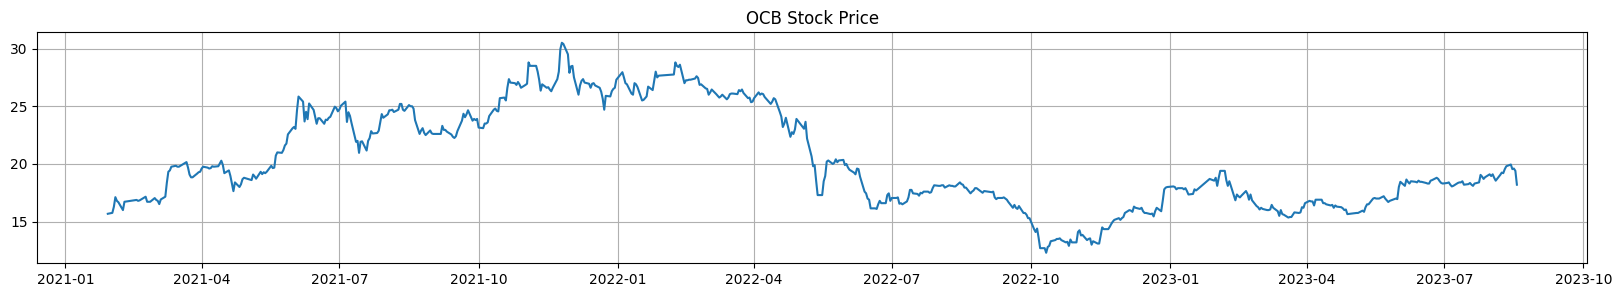

In [11]:
#data 633 x 4
plt.figure(figsize=(20,3))
plt.plot(df['Date'],df['Price'])
plt.title('OCB Stock Price')
plt.grid()
#_ = plt.xticks(df.index.values, df['Month'], rotation=60)
plt.show()

# Data Modeling

## Function

In [29]:
def DataSplitting(df,TrainRatio=0.9):
  '''
  Split data
  ----------
  Attributes:
  df : pd.DataFrame
  TrainRatio: float, default = 0.9
      train split ratio
  ----------
  Returns:
  dataset : pd.DataFrame
  splittingIndex: float
      splitting index
  ----------
  Example:
  dataset, splittingIndex = DataSplitting(df)
  '''
  # Create a new dataframe with only the 'Closed column
  data = df['Price']
  # Convert the dataframe to a numpy array
  dataset = data.values
  # Get the number of rows to train the model on --> Split the dataset
  splittingIndex = int(np.ceil(len(dataset)*TrainRatio))
  return dataset, splittingIndex

def create_dataset(dataset, lookback):
  '''
  Transform timeseries into a prediction dataset
  ----------
  Args:
   dataset: A np array of times series,
   lookback: size of window for prediction
  ----------
  Example:
  lookback = 20
  X_train, y_train = create_dataset(dataset,lookback)
  X_test y_test = create_dataset(dataset,lookback)
  '''
  X, y = [], []
  for i in range(len(dataset) - lookback):
    # Time series feature
    feature = dataset[i:i+lookback]
    # the Target is the next value
    target = dataset[i+1:i+lookback+1]
    X.append(feature)
    y.append(target)
  X = torch.tensor(X).unsqueeze(-1)
  y = torch.tensor(y).unsqueeze(-1)
  return X,y



In [30]:
class LSTM_model(nn.Module):
  '''
  Long-Short Term Memory with 1 LSTM and 1 NN as classifier
  if batch first --> input (batch, seq, feature) - (8,20,1)
  '''
  def __init__(self, input_dim=1, hidden_size=50, num_layers=1):
    super(LSTM_model,self).__init__()
    self.input_dim= input_dim
    self.hidden_size= hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
    # Classifier #  linear transformation, in_feature =50, out_one =1
    self.linear = nn.Linear(self.hidden_size,1)

  def forward(self,x):
    x,_ = self.lstm(x)
    x = self.linear(x)
    return x


class Conv_LSTM(nn.Module):
  '''
  2 Conv1D + LSTM with 1 LSTM and 1 NN as classifier
  if batch first --> input (batch, seq, feature) - (8,20,1)- input (batch, seq, feature) - (8,20,1) - out torch.Size([8, 4, 1])
  x torch.Size([8, 1, 20])
  p torch.Size([8, 50, 4])
  output torch.Size([8, 4, 50])
  output torch.Size([8, 4, 1])
  '''
  def __init__(self, input_size=1, hidden_size=50, output_size= 1, num_layers=1):
    super(Conv_LSTM,self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.num_layers = num_layers
    # ConV - 2
    self.c1 = nn.Conv1d(input_size, hidden_size, 2)
    self.p1 = nn.AvgPool1d(2)
    self.c2 = nn.Conv1d(hidden_size, hidden_size, 1)
    self.p2 = nn.AvgPool1d(2)
    # LSTM
    self.lstm = nn.LSTM(input_size=self.hidden_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)

    # Classifier #  linear transformation, in_feature =50, out_one =1
    self.linear = nn.Linear(self.hidden_size,self.output_size)


  def forward(self,x):    # ((8,20,1))
    x = x.transpose(1, 2) # torch.Size([8, 1, 20])
    # print('x',x.size())
        # Run through Conv1d and Pool1d layers: Conv1d+AvgPool -> Conv2d+AvgPool
    c = self.c1(x)
    p = self.p1(c)
    c = self.c2(p)
    p = self.p2(c)
    #print('p',p.size()) # torch.Size([8,50, 4])
    p = p.transpose(1, 2) # torch.Size([8,4, 50])
    output, _ = self.lstm(p)
    # print('output',output.size()) # torch.Size([8,4, 50])
    output = self.linear(output)
    # print('output',output.size()) # torch.Size([8,4, 1])
    return output


def test_model():
  '''
  # 8 - batch_size
  # 20- feature- lookback
  # 1 - series out of 8
  # test_model()
  '''
  x = torch.randn((8,20,1))
  model = LSTM_model()
  preds = model(x)
  print('x.shape',x.shape)
  print(preds.shape)

# test_model()
# x.shape torch.Size([8, 20, 1])
# torch.Size([8, 20, 1])

In [15]:
def train_fn(loader, model, optimizer, loss_fn, scaler,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.train()
    loop = tqdm(loader)
    running_loss =0
    for batch_idx, (data, targets) in enumerate(loop):
      # Get data to cuda if possible
      data = data.float().to(device=device)
      # Convert to the float and unsqueeze is reshape the target --> just 1 dimension
      targets = targets.float().to(device=device)
      # forward
      with torch.cuda.amp.autocast():
        '''
        Instances of torch.autocast enable autocasting for chosen regions.
        Autocasting automatically chooses the precision for GPU operations
        to improve performance while maintaining accuracy.
        '''
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()

      # backward
      optimizer.zero_grad()
      # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
      # Backward passes under autocast are not recommended.
      # Backward ops run in the same dtype autocast chose for corresponding forward ops.
      scaler.scale(loss).backward()
      # scaler.step() first unscales the gradients of the optimizer's assigned params.
      # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
      # otherwise, optimizer.step() is skipped.
      scaler.step(optimizer)
      # Updates the scale for next iteration.
      scaler.update()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

    return running_loss

def val_fn(loader, model, loss_fn,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.eval()
    running_loss =0
    for data, targets in loader:
      # Get data to cuda if possible
      data = data.float().to(device=device)
      targets = targets.float().to(device=device)

      # forward
      with torch.cuda.amp.autocast():
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()
    return running_loss

In [16]:
def train_fn_C_LSTM(loader, model, optimizer, loss_fn, scaler,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.train()
    loop = tqdm(loader)
    running_loss =0
    for batch_idx, (data, targets) in enumerate(loop):
      # Get data to cuda if possible
      data = data.float().to(device=device)
      # Convert to the float and unsqueeze is reshape the target --> just 1 dimension
      targets = targets.float().to(device=device)
      # forward
      with torch.cuda.amp.autocast():
        '''
        Instances of torch.autocast enable autocasting for chosen regions.
        Autocasting automatically chooses the precision for GPU operations
        to improve performance while maintaining accuracy.
        '''
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()

      # backward
      optimizer.zero_grad()
      # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
      # Backward passes under autocast are not recommended.
      # Backward ops run in the same dtype autocast chose for corresponding forward ops.
      scaler.scale(loss).backward()
      # scaler.step() first unscales the gradients of the optimizer's assigned params.
      # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
      # otherwise, optimizer.step() is skipped.
      scaler.step(optimizer)
      # Updates the scale for next iteration.
      scaler.update()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

    return running_loss

def val_fn_C_LSTM(loader, model, loss_fn,device):
    '''
    Training process
    model = MODEL().to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
      train_fn(trainLoader, model, optimizer, loss_fn, scaler,DEVICE)
    '''
    model.eval()
    running_loss =0
    for data, targets in loader:
      # Get data to cuda if possible
      data = data.float().to(device=device)
      targets = targets.float().to(device=device)

      # forward
      with torch.cuda.amp.autocast():
        preds = model(data)
        loss = loss_fn(preds, targets) #
        running_loss += loss.item()
    return running_loss

## Data Splitting

In [18]:
### main.py
lookback = 20
TrainRatio = 0.9
dataset, splittingIndex = DataSplitting(df,TrainRatio)
X_train, y_train = create_dataset(dataset[:splittingIndex-lookback],lookback)
X_test, y_test = create_dataset(dataset[splittingIndex-lookback:],lookback)

# Batch Processing - # train loader ([8,20,1])
trainLoader = DataLoader(TensorDataset(X_train,y_train),batch_size = BATCH_SIZE,num_workers = NUM_WORKERS,pin_memory = PIN_MEMORY,shuffle=True)
testLoader = DataLoader(TensorDataset(X_test,y_test),batch_size = BATCH_SIZE,num_workers = NUM_WORKERS,pin_memory = PIN_MEMORY,shuffle=True)

# Initialization
#model = MODEL().to(DEVICE)
model = LSTM_model().to(DEVICE)
# model = Conv_LSTM().to(DEVICE)
loss_fn = nn.MSELoss() # binary cross entropy loss function
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

# # Load model
# if LOAD_MODEL:
#   if not os.path.exists(savePath):
#     os.makedirs(savePath)
#   load_checkpoint(torch.load(savePath+ 'my_checkpoint.pth.tar'), model)

train_acc = []
train_loss = []
val_loss = []


In [19]:
for epoch in range(NUM_EPOCHS):
    print(f'The Epoch: {epoch}/{NUM_EPOCHS}')
    # Loss
    train_loss.append(train_fn(trainLoader, model, optimizer, loss_fn, scaler, DEVICE))
    val_loss.append(val_fn(testLoader,model,loss_fn,DEVICE))

    # # Save Check Point
    # checkpoint = {
    #     "state_dict": model.state_dict(),
    #     "optimizer": optimizer.state_dict(),
    # }
    # save_checkpoint(checkpoint)

The Epoch: 0/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 40.15it/s, loss=491]


The Epoch: 1/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 48.35it/s, loss=580]


The Epoch: 2/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 60.59it/s, loss=482]


The Epoch: 3/100


100%|█████████████████████████████████| 67/67 [00:00<00:00, 69.29it/s, loss=337]


The Epoch: 4/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 48.86it/s, loss=339]


The Epoch: 5/100


100%|█████████████████████████████████| 67/67 [00:00<00:00, 72.33it/s, loss=370]


The Epoch: 6/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 66.50it/s, loss=246]


The Epoch: 7/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 51.23it/s, loss=296]


The Epoch: 8/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 45.91it/s, loss=232]


The Epoch: 9/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 43.53it/s, loss=230]


The Epoch: 10/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 58.20it/s, loss=172]


The Epoch: 11/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 63.11it/s, loss=299]


The Epoch: 12/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 39.15it/s, loss=304]


The Epoch: 13/100


100%|█████████████████████████████████| 67/67 [00:00<00:00, 69.45it/s, loss=215]


The Epoch: 14/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 65.82it/s, loss=238]


The Epoch: 15/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 64.72it/s, loss=183]


The Epoch: 16/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 48.73it/s, loss=94.4]


The Epoch: 17/100


100%|█████████████████████████████████| 67/67 [00:02<00:00, 28.05it/s, loss=138]


The Epoch: 18/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 39.29it/s, loss=111]


The Epoch: 19/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 52.97it/s, loss=135]


The Epoch: 20/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 52.66it/s, loss=98.4]


The Epoch: 21/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 44.12it/s, loss=93.6]


The Epoch: 22/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 67.69it/s, loss=77.8]


The Epoch: 23/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 56.28it/s, loss=134]


The Epoch: 24/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 60.22it/s, loss=190]


The Epoch: 25/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 96.54it/s, loss=85.9]


The Epoch: 26/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 94.96it/s, loss=80.5]


The Epoch: 27/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 101.41it/s, loss=83.3]


The Epoch: 28/100


100%|█████████████████████████████████| 67/67 [00:00<00:00, 86.88it/s, loss=104]


The Epoch: 29/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 76.33it/s, loss=58.7]


The Epoch: 30/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 54.65it/s, loss=60.1]


The Epoch: 31/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 88.61it/s, loss=67.6]


The Epoch: 32/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 30.65it/s, loss=69.3]


The Epoch: 33/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 44.17it/s, loss=37.8]


The Epoch: 34/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 80.89it/s, loss=50.5]


The Epoch: 35/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 74.00it/s, loss=61.8]


The Epoch: 36/100


100%|██████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s, loss=38]


The Epoch: 37/100


100%|█████████████████████████████████| 67/67 [00:01<00:00, 57.92it/s, loss=115]


The Epoch: 38/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 85.51it/s, loss=50.9]


The Epoch: 39/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 107.02it/s, loss=52.6]


The Epoch: 40/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 100.37it/s, loss=76.5]


The Epoch: 41/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 69.48it/s, loss=38.5]


The Epoch: 42/100


100%|██████████████████████████████████| 67/67 [00:00<00:00, 92.10it/s, loss=26]


The Epoch: 43/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 91.01it/s, loss=29.3]


The Epoch: 44/100


100%|██████████████████████████████████| 67/67 [00:00<00:00, 70.81it/s, loss=35]


The Epoch: 45/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 86.06it/s, loss=32.6]


The Epoch: 46/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 100.25it/s, loss=28.7]


The Epoch: 47/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 87.93it/s, loss=30.6]


The Epoch: 48/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 100.18it/s, loss=43.3]


The Epoch: 49/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 83.03it/s, loss=24.9]


The Epoch: 50/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 111.93it/s, loss=43.1]


The Epoch: 51/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 102.28it/s, loss=48.7]


The Epoch: 52/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 113.55it/s, loss=23.2]


The Epoch: 53/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 98.28it/s, loss=28.4]


The Epoch: 54/100


100%|█████████████████████████████████| 67/67 [00:00<00:00, 106.70it/s, loss=33]


The Epoch: 55/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 113.27it/s, loss=38.2]


The Epoch: 56/100


100%|██████████████████████████████████| 67/67 [00:00<00:00, 94.30it/s, loss=11]


The Epoch: 57/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 113.93it/s, loss=24.1]


The Epoch: 58/100


100%|█████████████████████████████████| 67/67 [00:00<00:00, 115.39it/s, loss=27]


The Epoch: 59/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 111.76it/s, loss=36.4]


The Epoch: 60/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 79.70it/s, loss=28.2]


The Epoch: 61/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 103.65it/s, loss=43.3]


The Epoch: 62/100


100%|███████████████████████████████| 67/67 [00:00<00:00, 106.43it/s, loss=22.6]


The Epoch: 63/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 94.19it/s, loss=8.18]


The Epoch: 64/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 92.43it/s, loss=4.75]


The Epoch: 65/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 68.14it/s, loss=9.04]


The Epoch: 66/100


100%|████████████████████████████████| 67/67 [00:00<00:00, 80.36it/s, loss=14.3]


The Epoch: 67/100


100%|██████████████████████████████████| 67/67 [00:01<00:00, 66.39it/s, loss=12]


The Epoch: 68/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 26.88it/s, loss=18.8]


The Epoch: 69/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 31.92it/s, loss=31.2]


The Epoch: 70/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 34.86it/s, loss=27.2]


The Epoch: 71/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 48.88it/s, loss=18.8]


The Epoch: 72/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 35.71it/s, loss=20.2]


The Epoch: 73/100


100%|██████████████████████████████████| 67/67 [00:01<00:00, 47.93it/s, loss=34]


The Epoch: 74/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 47.08it/s, loss=25.8]


The Epoch: 75/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 44.23it/s, loss=28.4]


The Epoch: 76/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 39.77it/s, loss=16.6]


The Epoch: 77/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 28.45it/s, loss=16.9]


The Epoch: 78/100


100%|██████████████████████████████████| 67/67 [00:01<00:00, 41.27it/s, loss=19]


The Epoch: 79/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 40.72it/s, loss=21.5]


The Epoch: 80/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 40.46it/s, loss=18.5]


The Epoch: 81/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 45.89it/s, loss=12.7]


The Epoch: 82/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 31.58it/s, loss=25.4]


The Epoch: 83/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 25.26it/s, loss=13.8]


The Epoch: 84/100


100%|████████████████████████████████| 67/67 [00:03<00:00, 22.19it/s, loss=20.3]


The Epoch: 85/100


100%|██████████████████████████████████| 67/67 [00:01<00:00, 38.58it/s, loss=14]


The Epoch: 86/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 27.96it/s, loss=13.6]


The Epoch: 87/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 35.51it/s, loss=2.61]


The Epoch: 88/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 41.20it/s, loss=13.2]


The Epoch: 89/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 32.64it/s, loss=12.7]


The Epoch: 90/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 38.51it/s, loss=4.22]


The Epoch: 91/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 37.75it/s, loss=4.23]


The Epoch: 92/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 26.38it/s, loss=9.28]


The Epoch: 93/100


100%|████████████████████████████████| 67/67 [00:01<00:00, 36.34it/s, loss=17.1]


The Epoch: 94/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 33.06it/s, loss=2.07]


The Epoch: 95/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 26.13it/s, loss=3.77]


The Epoch: 96/100


100%|████████████████████████████████| 67/67 [00:04<00:00, 13.54it/s, loss=1.41]


The Epoch: 97/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 27.61it/s, loss=2.77]


The Epoch: 98/100


100%|████████████████████████████████| 67/67 [00:03<00:00, 21.12it/s, loss=6.09]


The Epoch: 99/100


100%|████████████████████████████████| 67/67 [00:02<00:00, 29.16it/s, loss=1.48]


In [20]:
def ResultPlot(train_loss,val_loss,NUM_EPOCHS,save=False):
  '''  
  Plot the result 
  ----------
  Attributes:
  train_loss : list
  val_loss: list
  NUM_EPOCHS: int
  save: bool
  ----------
  Example:
  ResultPlot(train_loss,val_loss,NUM_EPOCHS,save=False)
  '''
  num_epochs = [i for i in range(NUM_EPOCHS)]
  title1= 'The Model Loss'

  plt.plot(num_epochs,train_loss,label ='Train_loss')
  plt.plot(num_epochs,val_loss,label ='Val_loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title(title1)
  plt.legend()
  plt.grid()
  plt.show()

  if save:
      if not os.path.exists(savePath):
          os.makedirs(savePath)
      plt.savefig(savePath+f'{name_fig}.jpg')

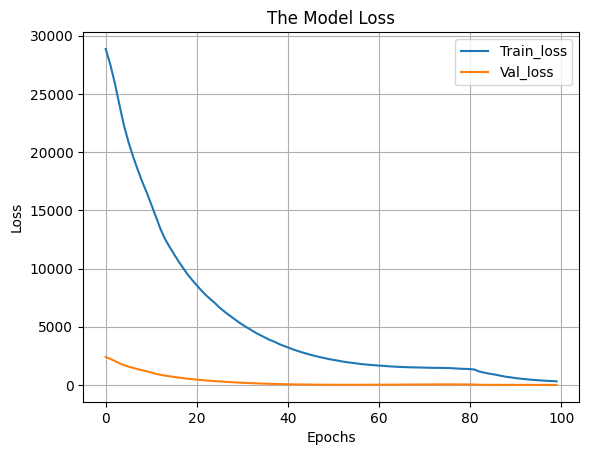

In [21]:
ResultPlot(train_loss,val_loss,NUM_EPOCHS,save=False)

# Visualization

In [22]:
# Plot the data
train = df[:splittingIndex]
valid = df[splittingIndex:]
X_test = X_test.float().to(device=DEVICE)
predictions = model(X_test)
# In case of using gpu - copy to cpu before process
predictions = predictions.cpu()

pred_value = predictions[:,-1,:].detach().numpy()
valid['Predictions'] = pred_value

## Evaluation

In [24]:
def BiTransform(input):
  if input>0:
    input = 1
  else :
    input = 0
  return input

valid['diff'] = valid['Predictions'] - valid['Price']
valid['diff'] =  valid['diff'].apply(BiTransform)
print( "Accuracy: ", valid['diff'].sum()/len(valid))

Accuracy:  0.5396825396825397


# Prediction

In [25]:
def VisualizationFigure():
  # Visualize the data
  plt.figure(figsize=(16,6))
  plt.title('Model')
  plt.xlabel('Date', fontsize=18)
  plt.ylabel('Close Price', fontsize=18)
  plt.plot(train['Price'])
  plt.plot(valid[['Price', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.grid()
  plt.show()
    
def Latest_Prediction():
  '''  
  Predict the latest day following
  ----------
  Attributes: 
  ----------
  Example:
  Latest_Prediction()
  '''
  X_last = torch.tensor(df['Price'][-lookback:].values).unsqueeze(-1)
  X_last = X_last.float().to(device=DEVICE)
  y_last_pred = model(X_last)
  y_last_pred = y_last_pred.cpu()
  y_last_pred = y_last_pred.detach().numpy()
  date = df_raw['Date'].values[0]
  res = y_last_pred[-1][0]
  last_price = df_raw['Price'].values[0]
  print(f'The last Price of OCB on {date}: {last_price}')
  print(f'The nextday Price of OCB: {res:.2f}')

In [26]:
Latest_Prediction()
print("Trend Prediction Accuracy:{:.2f} ".format(valid['diff'].sum()/len(valid)))

The last Price of OCB on 08/18/2023: 18,200.00
The nextday Price of OCB: 18.80
Trend Prediction Accuracy:0.54 


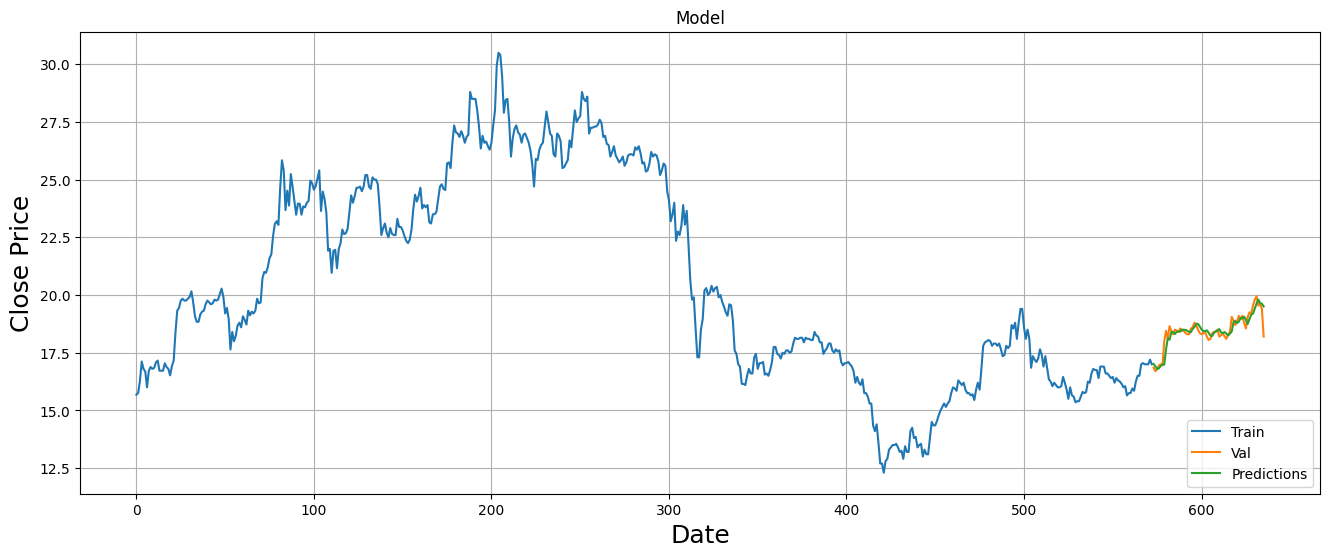

In [27]:
VisualizationFigure()